In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import operator
import string
import csv
import phrasemachine
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin

plt.rcParams['font.family'] = 'Helvetica'

In [2]:
f_adid_message = '../db-processing/adid_message.tsv'
ads = pd.read_csv(f_adid_message, sep='\t')
ads.set_index('ad_id', inplace=True)

f_adid_pid = '../db-processing/adid_pid.tsv'
ads_users = defaultdict(lambda: [])
with open(f_adid_pid, 'r') as fh:
    reader = csv.reader(fh, delimiter='\t')
    for row in reader:
        users = [x for x in row[1].split(',')]
        ads_users[int(row[0])] = users
        
def load_dem_file(filename):
    # Q22 = how would you cover a $400 random expense?
    # Q20 = kinds of debt
    # Q19 = how much are you saving?
    # Q18 = how often do you worry about debt?
    # Q12 = what industry did your parents work in?
    # Q11/Q11_14_TEXT = what industry do you work in
    user_demographics = {}
    df = pd.read_csv(filename)
    df.drop(labels=[0, 1], inplace=True)
    for i in range(df.shape[0]):
        pid = df['PROLIFIC_PID'].iloc[i]
        user_demographics[pid] = {
            '400_expense': df['Q22'].iloc[i],
            'debt': df['Q20'].iloc[i],
            'saving': df['Q19'].iloc[i]            
        }        
        
    return user_demographics
        
# also load user demographic map
demographics_file = '../db-processing/prolific-demographics.csv'
user_dem = load_dem_file(demographics_file)

In [3]:
# is there any user ad overlap?
for user in ads_users:
    if len(ads_users[user]) > 1:
        print(user, ads_users[user])
        
# max([len(users) for users in ads_users.values()])

6233283645787 ['5c6ac9e5d9c5be000174497f', '5bba226d70f8df0001c065f3']
23847571411330750 ['609471590c51b81087087049', '5e3cc28a194a520c0c128f13']
23847574201500787 ['609471590c51b81087087049', '5d1ea7e579b687001af802c6']
23847356524490423 ['5c6ac9e5d9c5be000174497f', '5d1ea7e579b687001af802c6', '5e3cc28a194a520c0c128f13']


In [4]:
parser = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words.update(['like', 'comment', 'share'])
punc = string.punctuation + "—’...…---™"

In [5]:
def clean_fb_strings(message):
    # removes fb-specific language from ad message
    cta_list = ['Apply Now', 'Book Now', 'Buy Tickets', 'Call Now', 'Contact Us',
        'Donate Now', 'Get Directions', 'Download', 'Get Offer', 'Get Quote', 'Get Showtimes', 'Install Now',
        'Learn More', 'Like Page', 'Listen Now', 'Open Link', 'Order Now', 'Play Game', 'Request Time', 'Save', 'See Menu',
        'Send Message', 'Send WhatsApp Message','Shop Now','Sign Up','Subscribe','Use App','View Event','Watch More']
    fb_keywords = ['Like', 'Comment', 'Share', 'See More']
    lines = []
    for line in message.split('\n'):
        if line not in cta_list and line not in fb_keywords:
            lines.append(line)
            
    # re-join back into one message
    return '\n'.join(list(set(lines)))
    

def spacy_tokenizer(message):
    # takes a full facebook message, removes fb-specific messages, and returns tokens
    global parser, stop_words, punc
    
    sent = clean_fb_strings(message)
    tokens = parser(sent)
    # spacy magic
    tokens = [word.lemma_.lower().strip() if word.lemma_ != '-PRON' else word.lower_ for word in tokens]
    # remove stop words and punctuation, also ignoring non-ascii chars for now
    # (might want to find a more nuance approach that retains emojis)
    tokens = [word for word in tokens if word not in stop_words and word not in punc and word.isascii()]
    
    return tokens

def phrasemachine_tokenizer(message):
    # takes a full facebook message, removes fb-specific messages, and returns
    sent = clean_fb_strings(message)    
    return phrasemachine.get_phrases(sent)
    

In [6]:
vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1, 1))
ads_list = ads['message'].tolist()
tf_matrix = vectorizer.fit_transform(ads_list)

In [7]:
print(tf_matrix.shape)

(748, 4954)


In [8]:
# TODO: use later once basic unigram pipeline is ready
# also, read about what this is actually accomplishing: https://github.com/slanglab/phrasemachine

ad = ads_list[25]
print(ad)
phrasemachine_tokenizer(ad)

Write a post-apocalyptic short fiction story for the chance to win $20,000!
Write a post-apocalyptic short fiction story for the chance to win $20,000!
About this partnership
vocal.media/challenges
Win $20,000 - Fiction Writing Challenge
Win $20,000 - Fiction Writing Challenge
Write a short piece of dystopian fiction involving a heart-shaped locket.
Sign Up
Like
Comment


{'num_tokens': 37,
 'counts': Counter({'post-apocalyptic short fiction': 1,
          'post-apocalyptic short fiction story': 1,
          'post-apocalyptic short fiction story for the chance': 1,
          'short fiction': 1,
          'short fiction story': 1,
          'short fiction story for the chance': 1,
          'fiction story': 1,
          'fiction story for the chance': 1,
          'story for the chance': 1,
          'partnership win': 1,
          'fiction writing': 1,
          'fiction writing challenge': 1,
          'writing challenge': 1,
          'short piece': 1,
          'short piece of dystopian fiction': 1,
          'piece of dystopian fiction': 1,
          'dystopian fiction': 1,
          'heart-shaped locket': 1})}

In [9]:
# top words in the database
matrix_np = tf_matrix.toarray()

freqs_computed = np.sum(matrix_np, axis=0)
maxfreqs = freqs_computed.argsort() 

# most frequent words
for i in range(20):
    maxfreq = maxfreqs[-(i+1)]
    ind_to_word = dict([v, k] for k, v in vectorizer.vocabulary_.items())
    print('freq:', freqs_computed[maxfreq], 'word:', ind_to_word[maxfreq])

freq: 345 word: shop
freq: 263 word: free
freq: 237 word: learn
freq: 216 word: new
freq: 136 word: sign
freq: 126 word: code
freq: 120 word: day
freq: 105 word: today
freq: 100 word: home
freq: 100 word: order
freq: 92 word: online
freq: 92 word: use
freq: 92 word: start
freq: 91 word: shipping
freq: 87 word: time
freq: 83 word: summer
freq: 82 word: book
freq: 81 word: good
freq: 77 word: save
freq: 75 word: jewelry


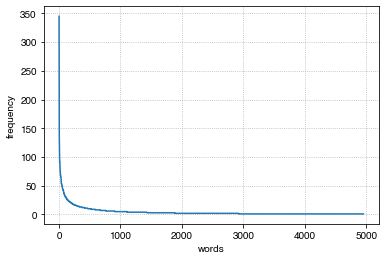

In [10]:
# sanity check by plotting frequencies (freqs_computed)
plt.plot(np.arange(len(freqs_computed)), sorted(freqs_computed, reverse=True))
# plt.xlim(left=0, right=50)
plt.xlabel('words')
# plt.xticks([])
plt.ylabel('frequency')
plt.grid(ls=':')

## Per-User Themes (tf-idf)

**idea**: each user's ads is one document, and the whole corpus is made up of $|users|$ documents
- top tf-idf terms from each document are the user's major themes

In [11]:
print('# ads:', len(ads_users))
allusers = []
list(map(lambda x: allusers.extend(x), ads_users.values()))
allusers = list(set(allusers))
print('# users:', len(allusers))

# compute per-user "document"
user_ads = {u: "" for u in allusers}
user_ad_counts = {u: 0 for u in allusers}
for adid, users in ads_users.items():
    for u in users:
        user_ads[u] += ads.loc[adid]['message'] + '\n'
        user_ad_counts[u] += 1

# ads: 748
# users: 7


In [12]:
# process user ads to get tf-idf
user_ads_tfidf = {u: None for u in allusers}
# allowing bigrams as well
user_vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1, 2))
corpus = [user_ads[u] for u in allusers]
    
# now pull out tfidf
ads_tfidf = user_vectorizer.fit_transform(corpus)
print(ads_tfidf.shape)

(7, 19165)


In [13]:
# top 10 words for each user
tfidf_np = ads_tfidf.toarray()

# top 10 most frequent words
ind_to_word = dict([v, k] for k, v in user_vectorizer.vocabulary_.items())
for i in range(tfidf_np.shape[0]):
    pid = allusers[i]
    print('\n -- user:', list(allusers)[i], f'(# ads: {user_ad_counts[pid]})', '-- demographics:')
    for dem in ['400_expense', 'debt', 'saving']:
        print(f'\t{dem}: {user_dem[pid][dem]}')
    print('\n')
    
    maxes = tfidf_np[i].argsort() 
    for j in range(15):
        curmax = maxes[-(j+1)]
        print('tf-idf:', round(tfidf_np[i][curmax], 4), 'word:', ind_to_word[curmax])


 -- user: 5e3cc28a194a520c0c128f13 (# ads: 11) -- demographics:
	400_expense: Sell something
	debt: Other debt, not including a home mortgage
	saving: Saving a little


tf-idf: 0.1806 word: solar
tf-idf: 0.1736 word: homeowner
tf-idf: 0.1632 word: roof
tf-idf: 0.1632 word: zip
tf-idf: 0.155 word: new
tf-idf: 0.136 word: battery backup
tf-idf: 0.136 word: battery
tf-idf: 0.136 word: backup
tf-idf: 0.1351 word: qualify
tf-idf: 0.1174 word: check
tf-idf: 0.1129 word: solar panel
tf-idf: 0.1129 word: panel
tf-idf: 0.1088 word: customer use
tf-idf: 0.1088 word: zip code
tf-idf: 0.1027 word: program

 -- user: 5bba226d70f8df0001c065f3 (# ads: 45) -- demographics:
	400_expense: Borrow from a friend or family member
	debt: Student loan debt,Credit card debt,Medical debt
	saving: Making ends meet


tf-idf: 0.1465 word: free
tf-idf: 0.1082 word: today
tf-idf: 0.1045 word: box
tf-idf: 0.095 word: care
tf-idf: 0.095 word: member
tf-idf: 0.0925 word: annual member
tf-idf: 0.0925 word: psychic frie

In [21]:
user_dem

{'5c0fcccc1f6f150001487111': {'400_expense': 'Use money currently in my checking or savings account or with cash',
  'debt': 'Auto loan debt',
  'saving': 'Saving a lot'},
 '5c6ac9e5d9c5be000174497f': {'400_expense': 'Sell something',
  'debt': 'Credit card debt,Medical debt',
  'saving': 'Making ends meet'},
 '5e3cc28a194a520c0c128f13': {'400_expense': 'Sell something',
  'debt': 'Other debt, not including a home mortgage',
  'saving': 'Saving a little'},
 '609471590c51b81087087049': {'400_expense': 'Use money currently in my checking or savings account or with cash',
  'debt': 'Medical debt',
  'saving': 'Saving a little'},
 '5bba226d70f8df0001c065f3': {'400_expense': 'Borrow from a friend or family member',
  'debt': 'Student loan debt,Credit card debt,Medical debt',
  'saving': 'Making ends meet'},
 '5d1ea7e579b687001af802c6': {'400_expense': 'Put it on my credit card and pay it off over time ,Use money currently in my checking or savings account or with cash,Borrow from a friend o

In [ ]:
# TODO: visualize all the ads for each one of these people

In [389]:
# testing whether phrasemachine is useful for us -- seems a little useful, but not too much
phrase_counts = phrasemachine_tokenizer(user_ads['609471590c51b81087087049'])
most_common = phrase_counts['counts'].most_common()[:15]
for ph, count in most_common:
    print(ph, count)
    
# phrasemachine only picks up on "noun phrases"

… see 16
sleep number 14
chef-cooked meals 11
metal poster 10
sleep number beds 9
number beds 9
top searches 9
see more 7
trevor wittman 6
north carolina 6
free shipping 6
hbo max 6
power punch 5
1 month 5
3 months 5


## User-level SVD Topic Modeling

In [22]:
print(tfidf_np.shape)
len(user_vectorizer.get_feature_names())

(7, 19168)


19168

In [23]:
from sklearn.decomposition import TruncatedSVD

# each row here is a user, so we're trying to find themes common across users (documents)
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=200, random_state=122)
svd_model.fit(tfidf_np)

TruncatedSVD(n_components=10, n_iter=200, random_state=122)

In [24]:
terms = user_vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:8]
    print("Topic " + str(i) + ": ")
    print(" ; ".join([t[0] for t in sorted_terms]), '\n')

Topic 0: 
free ; new ; day ; today ; plus ; good ; home ; meal 

Topic 1: 
air ; 99.97 ; 99.97 air ; air purifier ; kill ; purifier ; remove 99.97 ; remove 

Topic 2: 
solar ; homeowner ; roof ; zip ; qualify ; backup ; battery ; battery backup 

Topic 3: 
credit ; plus ; engagement ; engagement ring ; diamond ; ring ; bikini ; diamond engagement 

Topic 4: 
care ; annual member ; psychic friend ; bob ; member ; box ; psychic ; atlanta 

Topic 5: 
deliver fresh ; chef ; game ; search ; cook ; chef cook ; cook meal ; gaming 

Topic 6: 
earring ; jewelry ; woman ; necklace ; dress ; floral ; gogh ; collection 



In [25]:
# why did the SVD just stop at 7 topics? is this the maximum decomposition that can be done?
svd_model.explained_variance_ratio_.sum()

1.0

### SVD on the entire dataset (corpus-level themes)

In [26]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1, 2))
ads_list = ads['message'].tolist()
tfidf_matrix = tfidf_vectorizer.fit_transform(ads_list)

In [27]:
# every ad in this case is a document, so trying to find generic themes across ads
tfidf_matrix.shape

(748, 19050)

In [28]:
overall_svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=200, random_state=122)
overall_svd_model.fit(tfidf_matrix.toarray())

TruncatedSVD(n_components=10, n_iter=200, random_state=122)

In [29]:
terms = tfidf_vectorizer.get_feature_names()

for i, comp in enumerate(overall_svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic " + str(i) + \
          f' (explained variance {round(overall_svd_model.explained_variance_ratio_[i], 4)})' ": ")
    print(" ; ".join([t[0] for t in sorted_terms]), '\n')

Topic 0 (explained variance 0.0133): 
code new10 ; new10 ; code ; analuisa.com ; buzzfeed ; buzzfeed instyle ; elle ; elle refinery29 ; refinery29 ; refinery29 buzzfeed 

Topic 1 (explained variance 0.0111): 
new ; tracy ; anderson ; tracy anderson ; help achieve ; online studio ; achieve think ; anderson online ; core strategy ; design open 

Topic 2 (explained variance 0.0041): 
free ; shop ; learn ; day ; save ; amazon ; today ; order ; sign ; apply 

Topic 3 (explained variance 0.0069): 
fiction ; win ; win 20,000 ; write ; 20,000 ; chance win ; chance ; short ; honey ; dystopian 

Topic 4 (explained variance 0.0067): 
meal ; chef ; cook ; deliver fresh ; fresh ; meal deliver ; chef cook ; cook meal ; deliver ; fiction 

Topic 5 (explained variance 0.0065): 
summer ; test ; sale ; save 35 ; summer sale ; 35 ; 20 ; meal ; home ; sale 20 

Topic 6 (explained variance 0.0059): 
gogh ; van ; van gogh ; sign ; immersive ; immersive van ; book ; new ; family ; exhibit 

Topic 7 (explaine